In [ ]:
"""
3/12/2021
Baseline models with dataset of 1022 frames
Best performance: Random forests (AUC .75)
Examined bad photos that are predicted to be good

3/13/2021
Feature engineering:
    - Added Canny edges Laplacian variance (RF AUC -> .93.9!)

"""

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

## Load data and create df

In [157]:
blur = pd.read_pickle('./dump/blur_df')
face_info = pd.read_pickle('./dump/face_info_df')

In [158]:
df = pd.concat([blur.iloc[:,:-1],face_info.iloc[:,1:]],axis=1)
df

,filename,lp_cat,lp_all,lp_ratio,lp_cat_canny,lp_all_canny,lp_ratio_canny,blur,size_ratio,to_ctr,label
0,bad_0000.jpg,0.000000,22.753444,0.000000,0.000000,3001.808354,0.000000,1,0.000001,739.595836,bad
1,bad_0001.jpg,4.660371,151.710709,0.030719,8366.779563,22084.925770,0.378846,0,0.065138,75.643903,bad
2,bad_0002.jpg,82.495362,124.841606,0.660800,14106.747431,4192.945960,3.364400,0,0.091674,517.827191,bad
3,bad_0003.jpg,2.091063,40.310794,0.051874,24425.055787,3144.094380,7.768550,0,0.034277,155.322246,bad
4,bad_0004.jpg,6.651127,97.543566,0.068186,11455.725853,4035.024517,2.839072,0,0.074863,467.641957,bad
...,...,...,...,...,...,...,...,...,...,...,...
425,good_0425.jpg,2.431048,46.512277,0.052267,25312.325328,3044.992131,8.312772,0,0.040754,155.801155,good
426,good_0426.jpg,3.087013,94.492551,0.032669,32470.370416,5344.263256,6.075743,0,0.041603,368.228190,good
427,good_0427.jpg,1.495115,35.119939,0.042572,24792.418845,3016.606098,8.218646,0,0.019353,144.585615,good
428,good_0428.jpg,1.342932,56.748645,0.023665,28307.292100,4860.135045,5.824384,1,0.016823,154.159009,good


In [159]:
# Train test split
X = df.iloc[:,:-1]

mapping = {'bad':0, 'good':1}
y = df['label'].map(mapping)

X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

In [160]:
# Reset index
X_train_df.reset_index(inplace=True,drop=True)
X_test_df.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

In [161]:
X_test_df

,filename,lp_cat,lp_all,lp_ratio,lp_cat_canny,lp_all_canny,lp_ratio_canny,blur,size_ratio,to_ctr
0,good_0400.jpg,6.678660,68.185890,0.097948,37768.919477,7239.644416,5.216958,0,0.027317,440.164742
1,bad_0479.jpg,1.448002,41.623823,0.034788,28354.399939,5390.292788,5.260271,0,0.022061,177.282261
2,good_0097.jpg,5.136785,174.606556,0.029419,60146.446920,9271.330700,6.487359,1,0.070372,461.781334
3,bad_0031.jpg,8.349143,181.881367,0.045904,24695.425006,33638.991497,0.734131,0,0.030625,341.716257
4,good_0025.jpg,4.742959,138.281020,0.034299,20755.529985,4858.641025,4.271880,0,0.056875,322.262316
...,...,...,...,...,...,...,...,...,...,...
200,bad_0452.jpg,1.332098,61.481349,0.021667,33996.966542,6339.838574,5.362434,1,0.015234,133.899216
201,good_0125.jpg,2.900019,144.276161,0.020100,45480.224602,8366.560811,5.435952,1,0.050105,283.746366
202,good_0333.jpg,2.785324,122.736748,0.022693,23226.960105,4529.177735,5.128295,1,0.048710,309.181177
203,bad_0560.jpg,28.687493,58.173687,0.493135,7585.022737,2546.592990,2.978498,0,0.091674,585.103410


## Scale continuous variables

In [162]:
# Continuous variables
features = ['lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny', 'lp_all_canny', 'lp_ratio_canny', 'size_ratio', 'to_ctr']
X_train_con = X_train_df[features]

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train_con_scaled = scaler.fit_transform(X_train_df[features])
cont_columns = X_train_con.columns
X_train_con_df = pd.DataFrame(X_train_con_scaled, columns=cont_columns, index=X_train_con.index)
# X_train_con_df

In [163]:
# Try without 'blur'
X_train = X_train_con_df

In [101]:
# Combine Con and Cat
X_train = pd.concat([X_train_df[['blur']],X_train_con_df], axis='columns')
X_train

,blur,lp_cat,lp_all,lp_ratio,size_ratio,to_ctr
0,0,-0.232586,-0.735026,-0.192010,0.122065,-0.421185
1,1,-0.255792,-0.787508,-0.235555,-0.569909,-0.700983
2,0,-0.242751,-0.957512,-0.152219,-0.066723,-0.939454
3,1,-0.197967,0.605966,-0.263488,0.248174,0.275829
4,0,-0.194996,-0.582818,-0.151327,1.212259,-0.075042
...,...,...,...,...,...,...
812,1,-0.225143,0.669540,-0.284955,-0.165893,-1.047943
813,1,-0.234743,-0.429617,-0.241061,0.134395,-0.421905
814,0,-0.158899,-0.349438,-0.142205,0.394104,-0.156311
815,1,-0.235731,-0.451278,-0.240404,0.159242,-0.416492


In [164]:
# Repeat for test set
# Continuous variables
features = ['lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny', 'lp_all_canny', 'lp_ratio_canny', 'size_ratio', 'to_ctr']
X_test_con = X_test_df[features]

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_test_con_scaled = scaler.fit_transform(X_test_df[features])
cont_columns = X_test_con.columns
X_test_con_df = pd.DataFrame(X_test_con_scaled, columns=cont_columns, index=X_test_con.index)

# Combine Con and Cat
X_test = pd.concat([X_test_df[['blur']],X_test_con_df], axis='columns')
X_test

,blur,lp_cat,lp_all,lp_ratio,lp_cat_canny,lp_all_canny,lp_ratio_canny,size_ratio,to_ctr
0,0,-0.143866,-0.552437,-0.076512,0.285894,-0.392601,0.321231,-0.356462,0.493127
1,0,-0.268345,-0.923366,-0.249098,-0.140827,-0.534793,0.335576,-0.496533,-0.981655
2,1,-0.180560,0.933685,-0.263768,1.300175,-0.236389,0.741979,0.791046,0.614397
3,0,-0.104112,1.035275,-0.218722,-0.306673,1.637188,-1.163450,-0.268291,-0.059173
4,0,-0.189932,0.426413,-0.250432,-0.485252,-0.575671,0.008228,0.431320,-0.168311
...,...,...,...,...,...,...,...,...,...
200,1,-0.271103,-0.646063,-0.284952,0.114927,-0.461785,0.369412,-0.678487,-1.225035
201,1,-0.233790,0.510133,-0.289231,0.635416,-0.305955,0.393760,0.250881,-0.384387
202,1,-0.236519,0.209344,-0.282146,-0.373233,-0.601003,0.291866,0.213703,-0.241696
203,0,0.379897,-0.692254,1.003348,-1.082217,-0.753439,-0.420131,1.358785,1.306239


In [165]:
# Try without 'blur'
X_test = X_test_con_df

## 1. Logistic regression

In [166]:
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
print('intercept: ', round(lm.intercept_[0], 4))
pd.DataFrame(list(zip(X_train.columns,np.transpose(lm.coef_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)

intercept:  -0.3287


,Feature,Coef
6,size_ratio,[0.6421649489942863]
3,lp_cat_canny,[0.461001051831909]
1,lp_all,[0.3355060199243128]
5,lp_ratio_canny,[0.3224182479915942]
7,to_ctr,[0.25343515003596473]
0,lp_cat,[-0.046028351559845776]
4,lp_all_canny,[-0.3000493270679463]
2,lp_ratio,[-0.3561988035840715]


In [167]:
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-Bad (0)','Predict-Good (1)'],\
            index=['Bad (0)','Good (1)'])

,Predict-Bad (0),Predict-Good (1)
Bad (0),99,21
Good (1),51,34


In [168]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion/np.sum(fraud_confusion), cmap=plt.cm.Blues,
           annot=True, square=True, fmt='.2%',
           xticklabels=['Bad', 'Good'],
           yticklabels=['Bad', 'Good']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [169]:
from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [170]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.6487804878048781 

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.66      0.82      0.73       120
           1       0.62      0.40      0.49        85

    accuracy                           0.65       205
   macro avg       0.64      0.61      0.61       205
weighted avg       0.64      0.65      0.63       205



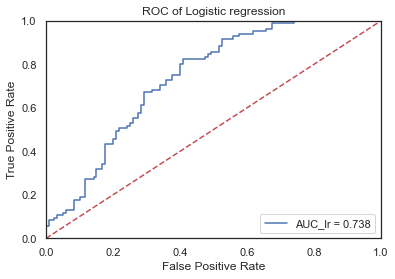

In [171]:
# Logistic regression ROC curve
y_scores = lm.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_lr = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of Logistic regression')
plt.show()

## 2. KNN 

In [172]:
from sklearn.neighbors import KNeighborsClassifier

knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train,y_train)
pred = knn_3.predict(X_test)

print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (kNN, n=3):\n\n',classification_report(y_test,pred))

Accuracy score: 0.824390243902439 

Classification report (kNN, n=3):

               precision    recall  f1-score   support

           0       0.83      0.88      0.85       120
           1       0.82      0.74      0.78        85

    accuracy                           0.82       205
   macro avg       0.82      0.81      0.82       205
weighted avg       0.82      0.82      0.82       205



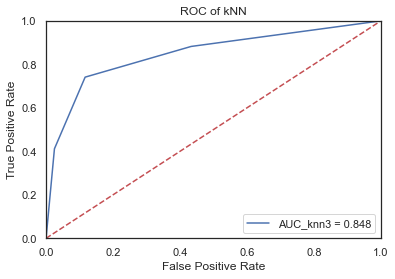

In [173]:
# knn=3 ROC curve
y_scores = knn_3.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'AUC_knn3 = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of kNN')
plt.show()

## 3. Naive Bayes

In [174]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train,y_train)
pred = nb.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Naive Bayes):\n\n',classification_report(y_test,pred))

Accuracy score: 0.6585365853658537 

Classification report (Naive Bayes):

               precision    recall  f1-score   support

           0       0.76      0.61      0.68       120
           1       0.57      0.73      0.64        85

    accuracy                           0.66       205
   macro avg       0.66      0.67      0.66       205
weighted avg       0.68      0.66      0.66       205



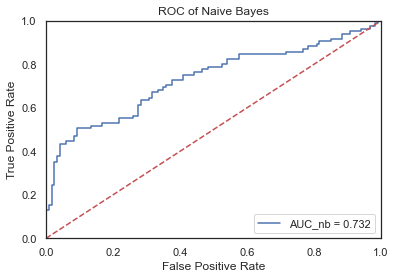

In [175]:
# Naive Bayes ROC curve
y_scores = nb.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_nb = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of Naive Bayes')
plt.show()

## 4. Decision tree - classification

In [176]:
def quick_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

def quick_test_afew_times(model, X_train, y_train, X_test, y_test, n=10):
    return np.mean([quick_test(model, X_train, y_train, X_test, y_test) for j in range(n)])

In [177]:
from sklearn.svm import LinearSVC
# Linear SVC
linearsvc = LinearSVC()

# Do the test 10 times with a LinearSVC and get the average score
quick_test_afew_times(linearsvc, X_train, y_train, X_test, y_test)

/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976

0.6424390243902438

In [178]:
from sklearn.tree import DecisionTreeClassifier
# Decision tree
decisiontree = DecisionTreeClassifier(max_depth=4)
quick_test_afew_times(decisiontree, X_train, y_train, X_test, y_test)

0.7463414634146341

In [179]:
pred = decisiontree.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Decision Tree):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7463414634146341 

Classification report (Decision Tree):

               precision    recall  f1-score   support

           0       0.80      0.75      0.78       120
           1       0.68      0.74      0.71        85

    accuracy                           0.75       205
   macro avg       0.74      0.75      0.74       205
weighted avg       0.75      0.75      0.75       205



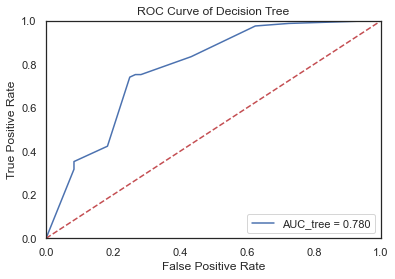

In [180]:
# Decision Tree ROC curve
y_scores = decisiontree.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_tree = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Decision Tree')
plt.show()

## 5. Random Forests

In [181]:
from sklearn.ensemble import RandomForestClassifier
# Random Forests
randomforest = RandomForestClassifier(n_estimators=100)
quick_test_afew_times(randomforest, X_train, y_train, X_test, y_test)

0.853170731707317

In [182]:
pred = randomforest.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Random Forests):\n\n',classification_report(y_test,pred))

Accuracy score: 0.8536585365853658 

Classification report (Random Forests):

               precision    recall  f1-score   support

           0       0.91      0.83      0.87       120
           1       0.79      0.88      0.83        85

    accuracy                           0.85       205
   macro avg       0.85      0.86      0.85       205
weighted avg       0.86      0.85      0.85       205



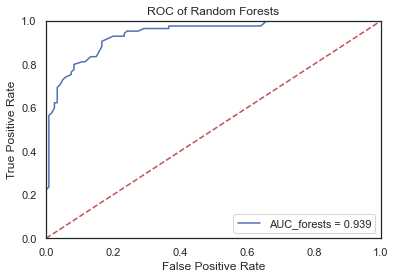

In [183]:
# Random Forests ROC curve
y_scores = randomforest.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_forests = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of Random Forests')
plt.show()

In [184]:
interactive(lambda threshold: make_confusion_matrix(randomforest, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [185]:
# y_scores

## Examine the results
Check false positive images

In [191]:
test_df = X_test_df.merge(y_test,left_index=True, right_index=True)

In [192]:
model = randomforest
threshold = 0.56
y_predict = (model.predict_proba(X_test)[:, 1] >= threshold).tolist()
test_df['pred'] = [0 if x==False else 1 for x in y_predict ]
test_df

,filename,lp_cat,lp_all,lp_ratio,lp_cat_canny,lp_all_canny,lp_ratio_canny,blur,size_ratio,to_ctr,label,pred
0,good_0400.jpg,6.678660,68.185890,0.097948,37768.919477,7239.644416,5.216958,0,0.027317,440.164742,1,1
1,bad_0479.jpg,1.448002,41.623823,0.034788,28354.399939,5390.292788,5.260271,0,0.022061,177.282261,0,0
2,good_0097.jpg,5.136785,174.606556,0.029419,60146.446920,9271.330700,6.487359,1,0.070372,461.781334,1,1
3,bad_0031.jpg,8.349143,181.881367,0.045904,24695.425006,33638.991497,0.734131,0,0.030625,341.716257,0,1
4,good_0025.jpg,4.742959,138.281020,0.034299,20755.529985,4858.641025,4.271880,0,0.056875,322.262316,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
200,bad_0452.jpg,1.332098,61.481349,0.021667,33996.966542,6339.838574,5.362434,1,0.015234,133.899216,0,0
201,good_0125.jpg,2.900019,144.276161,0.020100,45480.224602,8366.560811,5.435952,1,0.050105,283.746366,1,1
202,good_0333.jpg,2.785324,122.736748,0.022693,23226.960105,4529.177735,5.128295,1,0.048710,309.181177,1,1
203,bad_0560.jpg,28.687493,58.173687,0.493135,7585.022737,2546.592990,2.978498,0,0.091674,585.103410,0,0


In [193]:
# False-positive: bad photos but predicted to be good
FP = test_df[(test_df.label==0) & (test_df.pred==1)]
FP_img = FP.filename.tolist()
FP_len = len(FP_img)
FP_len

13

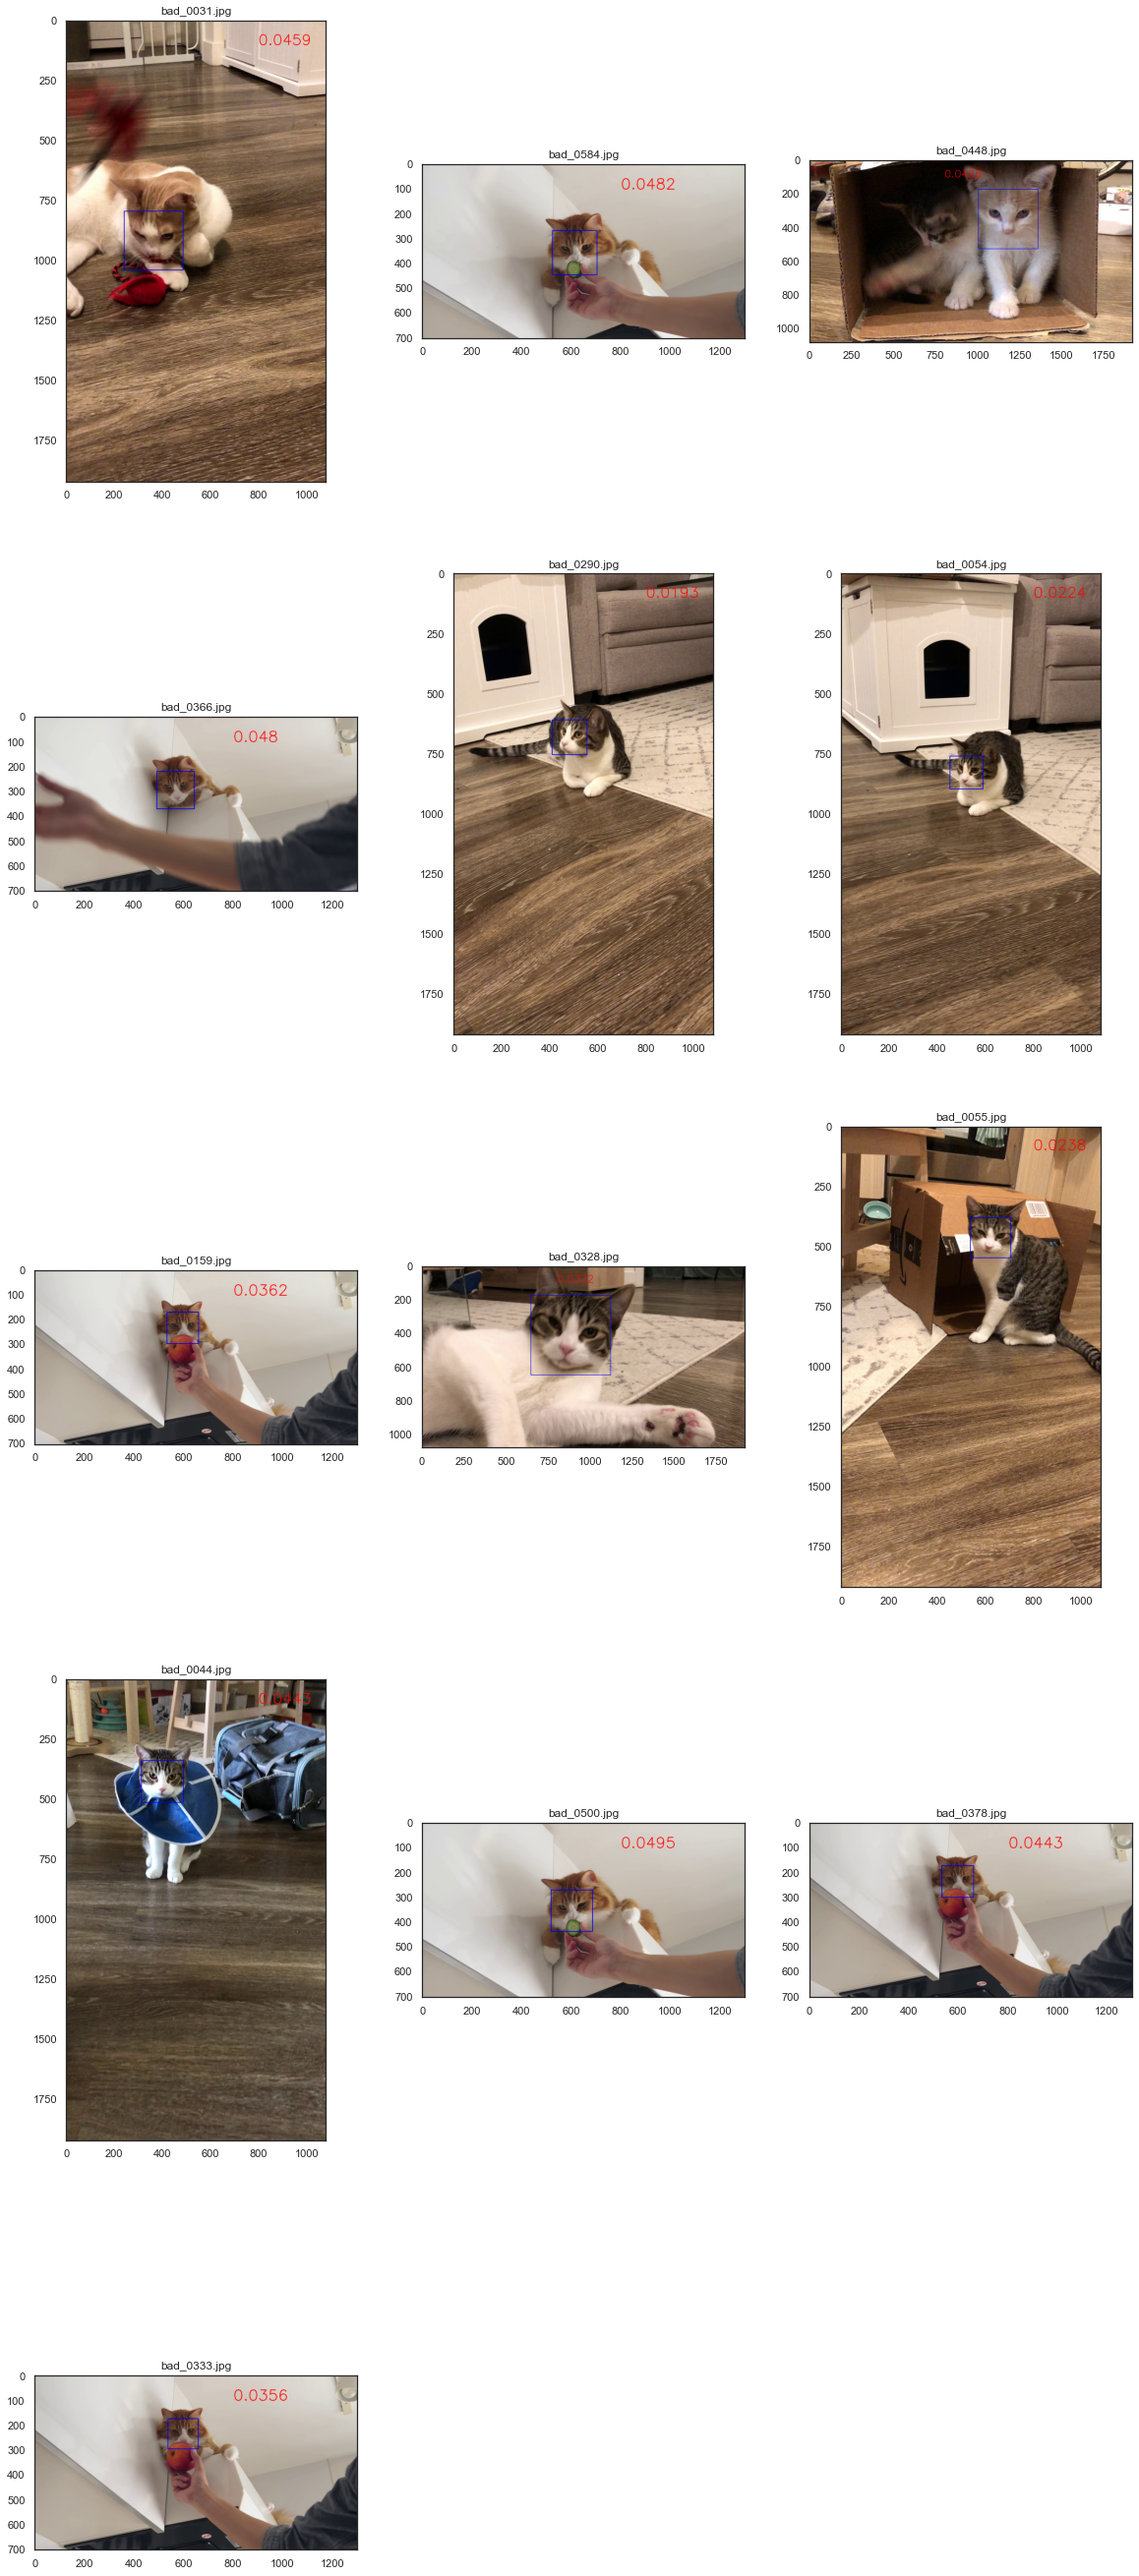

In [197]:
import cv2 as cv

# Text parameters 
font = cv.FONT_HERSHEY_SIMPLEX
org = (800, 100)
fontScale = 2
color = (255, 0, 0)
thickness = 2

# List of lp_ratio
lp_ratios = [round(x,4) for x in FP.lp_ratio.tolist()]

# Plots
subplot_row = FP_len//3+1
fig, axs = plt.subplots(figsize=(20, 10*subplot_row))
for i, filename in enumerate(FP_img[:]):
    img = cv.imread('OpenCV_blur/frame_bad_rename/'+filename)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    # Annotate lp_ratio
    lp_ratio = str(lp_ratios[i])
    rgb = cv.putText(rgb, lp_ratio,org, font,  
                   fontScale, color, thickness, cv.LINE_AA) 
    plt.subplot(subplot_row,3,i+1)
    plt.imshow(rgb)
    plt.title(filename)

plt.show()